In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import pathlib

## Loading data

In [2]:
directory_path = '../../04_-_Dev/videos'
features = 'eGeMAPS'#'emobase'

In [3]:
currentDirectory = pathlib.Path(directory_path)
currentPattern = "*." + features + ".annotated.csv"
file_list = [str(currentFile) for currentFile in currentDirectory.glob(currentPattern)]

In [4]:
df_total = pd.DataFrame()
for filename in file_list:
    df = pd.read_csv(filename, delimiter=';')
    df_total = pd.concat([df_total, df], axis=0)


In [5]:
print('Number of videos', df_total['video_name'].nunique())
print('Number of annotations', df_total[['video_name','diapo']].drop_duplicates().shape[0])

Number of videos 30
Number of annotations 240


In [6]:
df_total.loc[df_total.isna().any(axis=1),['video_name','frameTime']].value_counts()

video_name                       frameTime
WIN_20210417_14_53_12_Pro        0.01         1
                                 0.00         1
WIN_20210406_18_35_52_Pro        0.01         1
                                 0.00         1
WIN_20210406_15_06_15_Pro        0.01         1
                                 0.00         1
WIN_20210405_15_09_16_Pro        0.01         1
                                 0.00         1
WIN_20210404_21_41_12_Pro        0.01         1
                                 0.00         1
WIN_20210404_10_58_27_Pro        0.01         1
                                 0.00         1
WIN_20210403_18_49_15_Pro        0.01         1
                                 0.00         1
WIN_20210402_19_04_53_Pro        0.01         1
                                 0.00         1
WIN_20210402_14_27_50_Pro        0.01         1
                                 0.00         1
WIN_20210331_21_22_52_Pro        0.01         1
                                 0.00        

In [35]:
#df_total = df_total.drop(df_total.columns[0],axis=1)

In [9]:
df_total = df_total.dropna(axis=0)

In [36]:
df_total.to_pickle(directory_path + '/audio_' + features + '_data.p')

In [11]:
df_total = pd.read_pickle(directory_path + '/audio_' + features + '_data.p')

In [12]:
df_total.shape

(2492505, 78)

## Data exploration

In [12]:
df_total.groupby('diapo').agg({'frameTime':'mean'})


,frameTime
diapo,
1,99.359963
8,195.661667
9,270.161667
10,353.161667
11,434.661667
12,568.660055
17,659.128333
18,784.525699


In [13]:
df_stats_stress_global = df_total[['video_name','stress_global']].drop_duplicates()['stress_global'].value_counts().sort_index()
df_stats_stress_global


0.0    12
1.0    10
2.0     8
Name: stress_global, dtype: int64

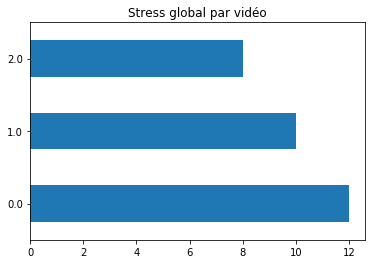

In [14]:
df_stats_stress_global.plot(kind='barh', title='Stress global par vidéo');


In [15]:
df_stats_stress = df_total[['video_name','diapo','stress']].drop_duplicates()['stress'].value_counts().sort_index()
df_stats_stress

0.0    101
1.0    113
2.0     25
3.0      1
Name: stress, dtype: int64

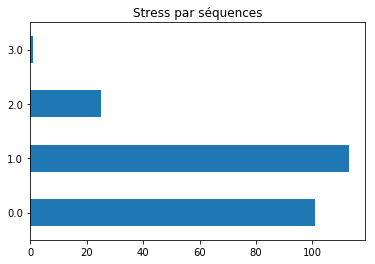

In [16]:
df_stats_stress.plot(kind='barh', title='Stress par séquences');

In [17]:
df_stats_stress_diapo = df_total[['video_name','diapo','stress']].drop_duplicates()[['diapo','stress']].groupby(['diapo','stress']).agg({'stress':'count'}).sort_index().unstack(fill_value=0)
df_stats_stress_diapo

stress            
stress    0.0 1.0 2.0 3.0
diapo                    
1          17  11   2   0
8          16  10   4   0
9          11  15   4   0
10         12  15   3   0
11         13  13   3   1
12          9  18   3   0
17         16  13   1   0
18          7  18   5   0

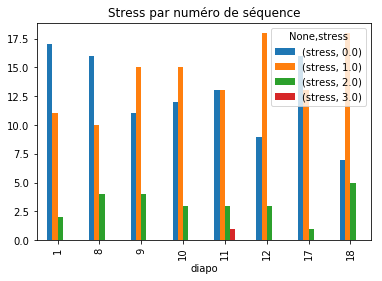

In [18]:
df_stats_stress_diapo.plot(kind='bar', title='Stress par numéro de séquence');

## Data pre-processing 1 - Sans utilisation de la temporalité

In [19]:
from scipy.stats import kurtosis, skew

def percentil25(x): 
    return np.percentile(x, q=25)

def percentil75(x): 
    return np.percentile(x, q=75)

In [37]:
df_total.columns

Index(['frameIndex', 'frameTime', 'Loudness_sma3', 'alphaRatio_sma3',
       'hammarbergIndex_sma3', 'slope0-500_sma3', 'slope500-1500_sma3',
       'spectralFlux_sma3', 'mfcc1_sma3', 'mfcc2_sma3', 'mfcc3_sma3',
       'mfcc4_sma3', 'F0semitoneFrom27.5Hz_sma3nz', 'jitterLocal_sma3nz',
       'shimmerLocaldB_sma3nz', 'HNRdBACF_sma3nz', 'logRelF0-H1-H2_sma3nz',
       'logRelF0-H1-A3_sma3nz', 'F1frequency_sma3nz', 'F1bandwidth_sma3nz',
       'F1amplitudeLogRelF0_sma3nz', 'F2frequency_sma3nz',
       'F2amplitudeLogRelF0_sma3nz', 'F3frequency_sma3nz',
       'F3amplitudeLogRelF0_sma3nz', 'Loudness_sma3_de', 'Loudness_sma3_de_de',
       'alphaRatio_sma3_de', 'alphaRatio_sma3_de_de',
       'hammarbergIndex_sma3_de', 'hammarbergIndex_sma3_de_de',
       'slope0-500_sma3_de', 'slope0-500_sma3_de_de', 'slope500-1500_sma3_de',
       'slope500-1500_sma3_de_de', 'spectralFlux_sma3_de',
       'spectralFlux_sma3_de_de', 'mfcc1_sma3_de', 'mfcc1_sma3_de_de',
       'mfcc2_sma3_de', 'mfcc2_sma3_d

In [38]:
# Sequence as a whole
X = df_total.iloc[:,2:].groupby(['video_name','diapo']).agg({'mean','min','max', 'median', 'std', percentil25, percentil75, kurtosis, skew}).iloc[:,:-18]

In [39]:
X.columns

MultiIndex([(                   'Loudness_sma3',    'kurtosis'),
            (                   'Loudness_sma3',         'max'),
            (                   'Loudness_sma3', 'percentil25'),
            (                   'Loudness_sma3',      'median'),
            (                   'Loudness_sma3',         'std'),
            (                   'Loudness_sma3',        'mean'),
            (                   'Loudness_sma3', 'percentil75'),
            (                   'Loudness_sma3',        'skew'),
            (                   'Loudness_sma3',         'min'),
            (                 'alphaRatio_sma3',    'kurtosis'),
            ...
            (   'F3amplitudeLogRelF0_sma3nz_de',         'min'),
            ('F3amplitudeLogRelF0_sma3nz_de_de',    'kurtosis'),
            ('F3amplitudeLogRelF0_sma3nz_de_de',         'max'),
            ('F3amplitudeLogRelF0_sma3nz_de_de', 'percentil25'),
            ('F3amplitudeLogRelF0_sma3nz_de_de',      'median'),
         

In [40]:
X

Loudness_sma3                                  \
                                     kurtosis       max percentil25    median   
video_name                diapo                                                 
Test_pour_AFPA            1        195.631236  3.545050    0.114812  0.119039   
                          8          1.922854  2.867280    0.117015  0.282706   
                          9          2.268561  3.393920    0.112834  0.209026   
                          10        10.863511  5.028640    0.111221  0.148684   
                          11         9.862057  5.151010    0.113637  0.252318   
...                                       ...       ...         ...       ...   
WIN_20210417_14_53_12_Pro 10         2.940143  3.264950    0.001104  0.013893   
                          11         1.568983  2.660928    0.001126  0.081050   
                          12         4.232695  0.384004    0.014089  0.029460   
                          17         0.669043  3.344785    0.006968  0.488653   
                          18        -0.914318  0.203776    0.001236  0.034392   

                                                                            \
                                      std      mean percentil75       skew   
video_name                diapo                                              
Test_pour_AFPA            1      0.130805  0.136717    0.124505  12.240252   
                          8      0.424739  0.460516    0.711492   1.370343   
                          9      0.383514  0.411576    0.639661   1.420768   
                          10     0.391520  0.382675    0.590052   2.289813   
                          11     0.381967  0.408419    0.605844   2.060058   
...                                   ...       ...         ...        ...   
WIN_20210417_14_53_12_Pro 10     0.464786  0.301682    0.547356   1.707042   
                          11     0.431815  0.330021    0.586716   1.397632   
                          12     0.038861  0.041404    0.058949   1.654525   
                          17     0.708703  0.651603    1.049473   1.121390   
                          18     0.037630  0.041692    0.075999   0.487773   

                                          alphaRatio_sma3  ...  \
                                      min        kurtosis  ...   
video_name                diapo                            ...   
Test_pour_AFPA            1      0.083114       35.764880  ...   
                          8      0.100229        0.110346  ...   
                          9      0.099458        0.410082  ...   
                          10     0.099492        0.166996  ...   
                          11     0.098327       -0.160992  ...   
...                                   ...             ...  ...   
WIN_20210417_14_53_12_Pro 10     0.001034        0.025470  ...   
                          11     0.001034       -0.130052  ...   
                          12     0.001034        0.938287  ...   
                          17     0.001034        0.245458  ...   
                          18     0.001034        0.822559  ...   

                                F3amplitudeLogRelF0_sma3nz_de  \
                                                          min   
video_name                diapo                                 
Test_pour_AFPA            1                         -68.80670   
                          8                         -84.51590   
                          9                         -82.88608   
                          10                        -83.92216   
                          11                        -85.56730   
...                                                       ...   
WIN_20210417_14_53_12_Pro 10                        -94.94055   
                          11                        -81.30158   
                          12                        -72.95505   
                          17                        -83.99115   
                          18      

In [22]:
#X = X.drop( ['type_candidat','sexe'],axis=1)

In [41]:
X_temp = df_total[['video_name','diapo','type_candidat','sexe']].groupby(['video_name','diapo']).agg({'type_candidat':'first','sexe':'first'})
X_temp.loc[X_temp['type_candidat'] == 'Stagiaire','Stagiaire'] = 1
X_temp.loc[X_temp['type_candidat'] != 'Stagiaire','Stagiaire'] = 0
X_temp.loc[X_temp['sexe'] == 'F','Femme'] = 1
X_temp.loc[X_temp['sexe'] != 'F','Femme'] = 0
X_temp = X_temp.drop(['type_candidat','sexe'], axis=1)

In [42]:
X_temp

Stagiaire  Femme
video_name                diapo                  
Test_pour_AFPA            1            1.0    0.0
                          8            1.0    0.0
                          9            1.0    0.0
                          10           1.0    0.0
                          11           1.0    0.0
...                                    ...    ...
WIN_20210417_14_53_12_Pro 10           1.0    1.0
                          11           1.0    1.0
                          12           1.0    1.0
                          17           1.0    1.0
                          18           1.0    1.0

[240 rows x 2 columns]

In [43]:
X = pd.concat([X,X_temp],axis=1)

In [44]:
X

(Loudness_sma3, kurtosis)  \
video_name                diapo                              
Test_pour_AFPA            1                     195.631236   
                          8                       1.922854   
                          9                       2.268561   
                          10                     10.863511   
                          11                      9.862057   
...                                                    ...   
WIN_20210417_14_53_12_Pro 10                      2.940143   
                          11                      1.568983   
                          12                      4.232695   
                          17                      0.669043   
                          18                     -0.914318   

                                 (Loudness_sma3, max)  \
video_name                diapo                         
Test_pour_AFPA            1                  3.545050   
                          8                  2.867280   
                          9                  3.393920   
                          10                 5.028640   
                          11                 5.151010   
...                                               ...   
WIN_20210417_14_53_12_Pro 10                 3.264950   
                          11                 2.660928   
                          12                 0.384004   
                          17                 3.344785   
                          18                 0.203776   

                                 (Loudness_sma3, percentil25)  \
video_name                diapo                                 
Test_pour_AFPA            1                          0.114812   
                          8                          0.117015   
                          9                          0.112834   
                          10                         0.111221   
                          11                         0.113637   
...                                                       ...   
WIN_20210417_14_53_12_Pro 10                         0.001104   
                          11                         0.001126   
                          12                         0.014089   
                          17                         0.006968   
                          18                         0.001236   

                                 (Loudness_sma3, median)  \
video_name                diapo                            
Test_pour_AFPA            1                     0.119039   
                          8                     0.282706   
                          9                     0.209026   
                          10                    0.148684   
                          11                    0.252318   
...                                                  ...   
WIN_20210417_14_53_12_Pro 10                    0.013893   
                          11                    0.081050   
                          12                    0.029460   
                          17                    0.488653   
                          18                    0.034392   

                                 (Loudness_sma3, std)  (Loudness_sma3, mean)  \
video_name                diapo                                                
Test_pour_AFPA            1                  0.130805               0.136717   
                          8                  0.424739               0.460516   
                          9                  0.383514               0.411576   
                          10                 0.391520               0.382675   
                          11                 0.381967               0.408419   
...                                               ...                    ...   
WIN_20210417_14_53_12_Pro 10                 0.464786               0.301682   
                          11                 0.431815               0.330021   
                          12                 0.038861    

In [45]:
y = df_total.iloc[:,2:].groupby(['video_name','diapo']).agg({'stress':'mean'}).iloc[:,-1]

In [46]:
y

video_name                 diapo
Test_pour_AFPA             1        1.0
                           8        1.0
                           9        0.0
                           10       0.0
                           11       0.0
                                   ... 
WIN_20210417_14_53_12_Pro  10       0.0
                           11       0.0
                           12       0.0
                           17       1.0
                           18       1.0
Name: stress, Length: 240, dtype: float64

In [47]:
X.to_pickle(directory_path + '/audio_' + features + '_data_X.p')
y.to_pickle(directory_path + '/audio_' + features + '_data_y.p')

In [48]:
from scipy.stats import kurtosis, skew
X_audio = df_total.loc[df_total['diapo'].isin([8, 9, 10, 11, 17]),:].iloc[:,2:].groupby(['video_name','diapo']).agg({'mean','min','max', 'median', 'std', percentil25, percentil75, kurtosis, skew}).iloc[:,:-18]
y_audio = df_total.loc[df_total['diapo'].isin([8, 9, 10, 11, 17]),:].iloc[:,2:].groupby(['video_name','diapo']).agg({'stress':'mean'}).iloc[:,-1]


In [49]:
X_audio.to_pickle(directory_path + '/audio_' + features + '_data_X_audio.p')
y_audio.to_pickle(directory_path + '/audio_' + features + '_data_y_audio.p')

## Modèles

In [3]:
X = pd.read_pickle(directory_path + '/audio_' + features + '_data_X.p')
y = pd.read_pickle(directory_path + '/audio_' + features + '_data_y.p')

X_audio = pd.read_pickle(directory_path + '/audio_' + features + '_data_X_audio.p')
y_audio = pd.read_pickle(directory_path + '/audio_' + features + '_data_y_audio.p')

In [4]:
X.shape

(240, 623)

In [51]:
X = X.fillna(0)

In [52]:
X

(Loudness_sma3, kurtosis)  \
video_name                diapo                              
Test_pour_AFPA            1                     195.631236   
                          8                       1.922854   
                          9                       2.268561   
                          10                     10.863511   
                          11                      9.862057   
...                                                    ...   
WIN_20210417_14_53_12_Pro 10                      2.940143   
                          11                      1.568983   
                          12                      4.232695   
                          17                      0.669043   
                          18                     -0.914318   

                                 (Loudness_sma3, max)  \
video_name                diapo                         
Test_pour_AFPA            1                  3.545050   
                          8                  2.867280   
                          9                  3.393920   
                          10                 5.028640   
                          11                 5.151010   
...                                               ...   
WIN_20210417_14_53_12_Pro 10                 3.264950   
                          11                 2.660928   
                          12                 0.384004   
                          17                 3.344785   
                          18                 0.203776   

                                 (Loudness_sma3, percentil25)  \
video_name                diapo                                 
Test_pour_AFPA            1                          0.114812   
                          8                          0.117015   
                          9                          0.112834   
                          10                         0.111221   
                          11                         0.113637   
...                                                       ...   
WIN_20210417_14_53_12_Pro 10                         0.001104   
                          11                         0.001126   
                          12                         0.014089   
                          17                         0.006968   
                          18                         0.001236   

                                 (Loudness_sma3, median)  \
video_name                diapo                            
Test_pour_AFPA            1                     0.119039   
                          8                     0.282706   
                          9                     0.209026   
                          10                    0.148684   
                          11                    0.252318   
...                                                  ...   
WIN_20210417_14_53_12_Pro 10                    0.013893   
                          11                    0.081050   
                          12                    0.029460   
                          17                    0.488653   
                          18                    0.034392   

                                 (Loudness_sma3, std)  (Loudness_sma3, mean)  \
video_name                diapo                                                
Test_pour_AFPA            1                  0.130805               0.136717   
                          8                  0.424739               0.460516   
                          9                  0.383514               0.411576   
                          10                 0.391520               0.382675   
                          11                 0.381967               0.408419   
...                                               ...                    ...   
WIN_20210417_14_53_12_Pro 10                 0.464786               0.301682   
                          11                 0.431815               0.330021   
                          12                 0.038861    

In [55]:
video_list = sorted(df_total.video_name.unique())
split_index = int(0.7 * len(video_list))
print(split_index)
train_video_list = video_list[:split_index]
test_video_list = video_list[split_index:]
print('train',train_video_list, len(train_video_list))
print('test',test_video_list, len(test_video_list))

21
train ['Test_pour_AFPA', 'Video_1', 'WIN_20210323_19_17_40_Pro', 'WIN_20210329_10_16_02_Pro', 'WIN_20210330_13_10_29_Pro', 'WIN_20210331_21_22_52_Pro', 'WIN_20210402_14_27_50_Pro', 'WIN_20210402_19_04_53_Pro', 'WIN_20210403_18_49_15_Pro', 'WIN_20210404_10_58_27_Pro', 'WIN_20210404_21_41_12_Pro', 'WIN_20210405_15_09_16_Pro', 'WIN_20210406_15_06_15_Pro', 'WIN_20210406_18_35_52_Pro', 'WIN_20210406_18_49_10_Pro', 'WIN_20210406_21_05_52_Pro', 'WIN_20210407_09_04_05_Pro', 'WIN_20210407_14_54_56_Pro_edit2', 'WIN_20210408_11_48_58_Pro', 'WIN_20210408_14_00_44_Pro', 'WIN_20210408_14_02_19_Pro'] 21
test ['WIN_20210408_14_11_32_Pro', 'WIN_20210408_15_20_51_Pro', 'WIN_20210408_16_04_32_Pro', 'WIN_20210409_10_26_11_Pro', 'WIN_20210413_15_38_01_Pro', 'WIN_20210414_06_24_52_Pro', 'WIN_20210415_15_41_24_Pro', 'WIN_20210416_08_06_54_Pro', 'WIN_20210417_14_53_12_Pro'] 9


In [56]:
#from sklearn.model_selection import train_test_split
#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42 )
Xtrain = X.loc[train_video_list,:,:]
Xtest = X.loc[test_video_list,:,:]
ytrain = y.loc[train_video_list,:,:]
ytest = y.loc[test_video_list,:,:]

In [57]:
Xtrain

(Loudness_sma3, kurtosis)  \
video_name                diapo                              
Test_pour_AFPA            1                     195.631236   
                          8                       1.922854   
                          9                       2.268561   
                          10                     10.863511   
                          11                      9.862057   
...                                                    ...   
WIN_20210408_14_02_19_Pro 10                      0.861306   
                          11                      2.555600   
                          12                     23.329275   
                          17                      3.904827   
                          18                     34.103144   

                                 (Loudness_sma3, max)  \
video_name                diapo                         
Test_pour_AFPA            1                  3.545050   
                          8                  2.867280   
                          9                  3.393920   
                          10                 5.028640   
                          11                 5.151010   
...                                               ...   
WIN_20210408_14_02_19_Pro 10                 2.244787   
                          11                 2.486140   
                          12                 1.163112   
                          17                 1.052434   
                          18                 1.263541   

                                 (Loudness_sma3, percentil25)  \
video_name                diapo                                 
Test_pour_AFPA            1                          0.114812   
                          8                          0.117015   
                          9                          0.112834   
                          10                         0.111221   
                          11                         0.113637   
...                                                       ...   
WIN_20210408_14_02_19_Pro 10                         0.112302   
                          11                         0.132400   
                          12                         0.037797   
                          17                         0.036804   
                          18                         0.038393   

                                 (Loudness_sma3, median)  \
video_name                diapo                            
Test_pour_AFPA            1                     0.119039   
                          8                     0.282706   
                          9                     0.209026   
                          10                    0.148684   
                          11                    0.252318   
...                                                  ...   
WIN_20210408_14_02_19_Pro 10                    0.330156   
                          11                    0.320067   
                          12                    0.042742   
                          17                    0.041481   
                          18                    0.043233   

                                 (Loudness_sma3, std)  (Loudness_sma3, mean)  \
video_name                diapo                                                
Test_pour_AFPA            1                  0.130805               0.136717   
                          8                  0.424739               0.460516   
                          9                  0.383514               0.411576   
                          10                 0.391520               0.382675   
                          11                 0.381967               0.408419   
...                                               ...                    ...   
WIN_20210408_14_02_19_Pro 10                 0.324273               0.393138   
                          11                 0.311915               0.388630   
                          12                 0.130244    

In [58]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [60]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True)
lr.fit(Xtrain,ytrain)

ytrain_predict = lr.predict(Xtrain)
ytrain_predict[ytrain_predict<0] = 0.0
ytrain_predict[ytrain_predict>3] = 3.0

ypredict = lr.predict(Xtest)
ypredict[ypredict<0] = 0.0
ypredict[ypredict>3] = 3.0

print('TRAIN : mean_squared_error without rounding the prediction', mean_squared_error(ytrain_predict, ytrain, squared=False))
print('TEST : mean_squared_error without rounding the prediction', mean_squared_error(ypredict, ytest, squared=False))
print('TEST : mean_squared_error with rounding the prediction', mean_squared_error(np.round(ypredict,0), ytest, squared=False))

TRAIN : mean_squared_error without rounding the prediction 2.937673739728373e-15
TEST : mean_squared_error without rounding the prediction 1.1344498195378623
TEST : mean_squared_error with rounding the prediction 1.1486707293408518


In [61]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=7, random_state=42)
dt.fit(Xtrain, ytrain)

ytrain_predict = dt.predict(Xtrain)
ytrain_predict[ytrain_predict<0] = 0.0
ytrain_predict[ytrain_predict>3] = 3.0

ypredict = dt.predict(Xtest)
ypredict[ypredict<0] = 0.0
ypredict[ypredict>3] = 3.0

print('TRAIN : mean_squared_error without rounding the prediction', mean_squared_error(ytrain_predict, ytrain, squared=False))
print('TEST : mean_squared_error', mean_squared_error(ypredict, ytest, squared=False))
print('TEST : mean_squared_error with rounding the prediction', mean_squared_error(np.round(ypredict,0), ytest, squared=False))

TRAIN : mean_squared_error without rounding the prediction 0.1059456926727952
TEST : mean_squared_error 1.0629719173393783
TEST : mean_squared_error with rounding the prediction 1.0671873729054748


In [63]:
#print(dt.feature_importances_)
print(np.argsort(dt.feature_importances_)[:-20:-1])
print(X.columns[np.argsort(dt.feature_importances_)[:-20:-1]])

[422 331 590 142  62 283 131 495 314  11 277 368 567 514  99 115  28 468
  47]
Index([          ('jitterLocal_sma3nz_de_de', 'min'),
                        ('mfcc1_sma3_de_de', 'skew'),
                   ('F3frequency_sma3nz_de', 'mean'),
                   ('logRelF0-H1-A3_sma3nz', 'skew'),
                               ('mfcc1_sma3', 'min'),
                    ('slope500-1500_sma3_de', 'std'),
                   ('logRelF0-H1-H2_sma3nz', 'mean'),
               ('F1frequency_sma3nz_de', 'kurtosis'),
                  ('spectralFlux_sma3_de_de', 'min'),
                  ('alphaRatio_sma3', 'percentil25'),
                   ('slope0-500_sma3_de_de', 'skew'),
                         ('mfcc3_sma3_de_de', 'min'),
       ('F2amplitudeLogRelF0_sma3nz_de', 'kurtosis'),
                    ('F1bandwidth_sma3nz_de', 'max'),
                  ('jitterLocal_sma3nz', 'kurtosis'),
                   ('shimmerLocaldB_sma3nz', 'skew'),
                          ('slope0-500_sma3', 'max'),
   

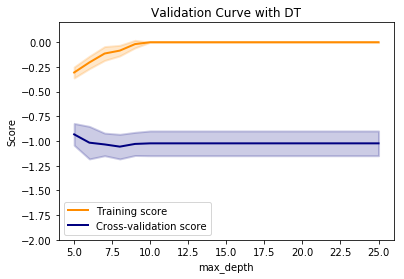

In [64]:
from sklearn.model_selection import validation_curve
param_range = [5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 20, 25]
train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(random_state=42), X, y, param_name="max_depth", param_range=param_range,
    scoring="neg_root_mean_squared_error", n_jobs=8)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with DT")
plt.xlabel(r"max_depth")
plt.ylabel("Score")
plt.ylim(-2, 0.2)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [65]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(Xtrain, ytrain)
ytrain_predict = dt.predict(Xtrain)
ypredict = dt.predict(Xtest)
#ypredict[ypredict<0] = 0.0
#ypredict[ypredict>3] = 3.0
print('TRAIN : mean_squared_error without rounding the prediction', mean_squared_error(ytrain_predict, ytrain, squared=False))
print('TEST : mean_squared_error', mean_squared_error(ypredict, ytest, squared=False))

TRAIN : mean_squared_error without rounding the prediction 0.17251638983558856
TEST : mean_squared_error 1.3844373104863459


In [66]:
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=42)
rf.fit(Xtrain, ytrain)

ytrain_predict = rf.predict(Xtrain)
ytrain_predict[ytrain_predict<0] = 0.0
ytrain_predict[ytrain_predict>3] = 3.0

ypredict = rf.predict(Xtest)
ypredict[ypredict<0] = 0.0
ypredict[ypredict>3] = 3.0

print('TRAIN : mean_squared_error without rounding the prediction', mean_squared_error(ytrain_predict, ytrain, squared=False))
print('TEST : mean_squared_error without rounding the prediction', mean_squared_error(ypredict, ytest, squared=False))
print('TEST : mean_squared_error with rounding the prediction', mean_squared_error(np.round(ypredict,0), ytest, squared=False))

TRAIN : mean_squared_error without rounding the prediction 0.22406691057497663
TEST : mean_squared_error without rounding the prediction 0.7624314465721057
TEST : mean_squared_error with rounding the prediction 0.8333333333333334


In [69]:
print(X.columns[np.argsort(rf.feature_importances_)[:-20:-1]])

Index([               ('hammarbergIndex_sma3', 'min'),
                     ('logRelF0-H1-A3_sma3nz', 'max'),
              ('shimmerLocaldB_sma3nz_de_de', 'skew'),
                  ('jitterLocal_sma3nz_de_de', 'min'),
                     ('jitterLocal_sma3nz_de', 'min'),
                         ('mfcc1_sma3_de_de', 'skew'),
                     ('HNRdBACF_sma3nz_de_de', 'min'),
                          ('mfcc3_sma3_de', 'median'),
                    ('logRelF0-H1-H2_sma3nz', 'mean'),
                     ('slope500-1500_sma3_de', 'std'),
         ('F1amplitudeLogRelF0_sma3nz_de_de', 'skew'),
         ('F2amplitudeLogRelF0_sma3nz_de_de', 'skew'),
                           ('slope0-500_sma3', 'min'),
                           ('slope0-500_sma3', 'std'),
                 ('F1bandwidth_sma3nz_de_de', 'mean'),
                 ('F1frequency_sma3nz_de_de', 'mean'),
                             ('mfcc3_sma3_de', 'std'),
       ('F0semitoneFrom27.5Hz_sma3nz', 'percentil75'),
          

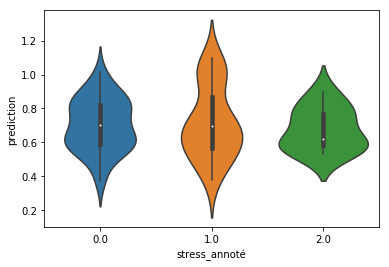

In [70]:
import seaborn as sns
df_compare = pd.DataFrame(np.stack([ypredict, ytest],axis=1),columns=['prediction','stress_annoté'])
df_compare
sns.violinplot(x="stress_annoté", y="prediction", data=df_compare)

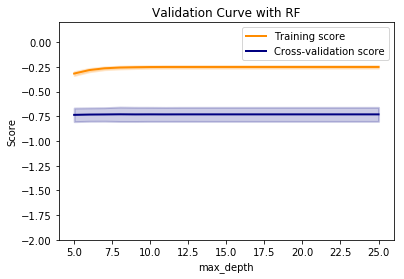

In [48]:
from sklearn.model_selection import validation_curve
param_range = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25]
train_scores, test_scores = validation_curve(
    RandomForestRegressor(n_estimators=100, random_state=42), X, y, param_name="max_depth", param_range=param_range,
    scoring="neg_root_mean_squared_error", n_jobs=8)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RF")
plt.xlabel(r"max_depth")
plt.ylabel("Score")
plt.ylim(-2, 0.2)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [71]:
from xgboost import XGBClassifier
rf = XGBClassifier(n_estimators=100, max_depth=20, use_label_encoder=False,  objective='multi:softmax', num_class=4,)
rf.fit(Xtrain, ytrain, eval_metric='rmse')
ypredict = rf.predict(Xtest)
print('mean_squared_error', mean_squared_error(ypredict, ytest, squared=False))

mean_squared_error 0.8333333333333334


In [72]:
from xgboost import XGBRegressor
rf = XGBRegressor(n_estimators=100, max_depth=20)
rf.fit(Xtrain, ytrain, eval_metric='rmse')
ypredict = rf.predict(Xtest)
ypredict[ypredict<0] = 0.0
ypredict[ypredict>3] = 3.0
print('mean_squared_error', mean_squared_error(ypredict, ytest, squared=False))

mean_squared_error 0.818571858244359


In [51]:
print('mean_squared_error', mean_squared_error(np.round(ypredict,0), ytest, squared=False))

mean_squared_error 0.9646530752325188


In [52]:
ytest.values

array([0., 2., 2., 2., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 2., 2., 2., 2., 2., 1., 1., 2., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 2., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1.])

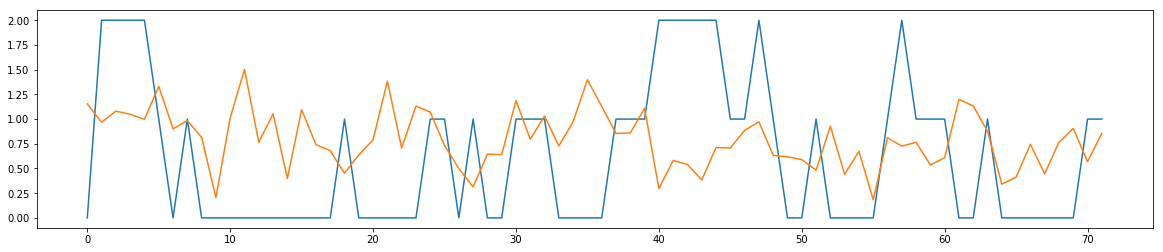

In [73]:
plt.figure(figsize=(20,4))
plt.plot(ytest.values, label='test')
plt.plot(ypredict, label='test predict')

(array([10., 20., 10., 14.,  7.,  5.,  6.]),
 array([-1.50284791, -1.04482194, -0.58679598, -0.12877001,  0.32925596,
         0.78728192,  1.24530789,  1.70333385]),
 <a list of 7 Patch objects>)

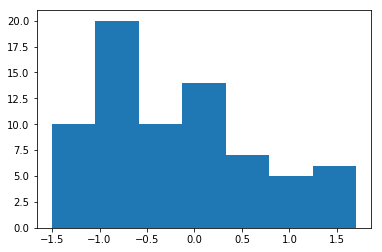

In [75]:
plt.hist(ytest.values - ypredict, bins = 7, label='test predict')

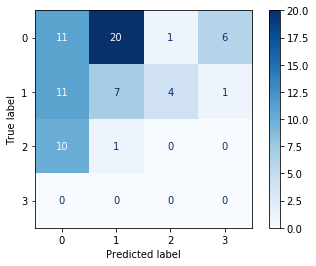

In [77]:
from sklearn.metrics import plot_confusion_matrix
class_names = [0,1,2,3]
disp = plot_confusion_matrix(dt, Xtest, ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None )#'true','pred', 'all'                                 )


## Classifiers

In [78]:
ypredict_list, ytest_list = [], []

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    rf = RandomForestClassifier(max_depth=7, n_estimators=100, random_state=42)
    rf.fit(Xtrain, ytrain)
    ypredict = rf.predict(Xtest)

    ypredict_list = np.concatenate([ypredict_list,ypredict])
    ytest_list = np.concatenate([ytest_list,ytest])

/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


In [80]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
print(confusion_matrix(ytest_list, ypredict_list))
print('accuracy',accuracy_score(ytest_list,ypredict_list))
print('f1', f1_score(ytest_list, ypredict_list,labels=[0,1,2,3],average='weighted'))


[[65 36  0  0]
 [33 78  2  0]
 [ 4 21  0  0]
 [ 0  1  0  0]]
accuracy 0.5958333333333333
f1 0.5644790986606523


In [81]:
import ordinal_classification as o_c
#For ordinal classif
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(max_depth=7, n_estimators=100, random_state = 42)
model2 = RandomForestClassifier(max_depth=7, n_estimators=100, random_state = 42)
model3 = RandomForestClassifier(max_depth=7, n_estimators=100, random_state = 42)
list_models = [model1, model2, model3]

ypredict_list, ytest_list = [], []


from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    ypredict = o_c.ordinal_classification(list_models, Xtrain, ytrain, Xtest)

    ypredict_list = np.concatenate([ypredict_list,ypredict])
    ytest_list = np.concatenate([ytest_list,ytest])


/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


IndexError: index 1 is out of bounds for axis 1 with size 1

In [82]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
print(confusion_matrix(ytest_list, ypredict_list))
print(accuracy_score(ytest_list,ypredict_list))
print(f1_score(ytest_list, ypredict_list,labels=[0,1,2,3],average='weighted'))

[[53 23  0]
 [27 56  2]
 [ 1 15  3]]
0.6222222222222222
0.6069247747373748
/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


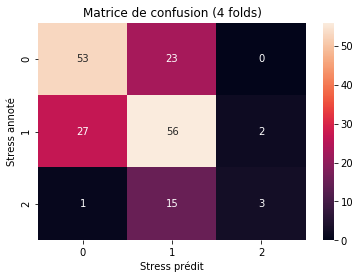

In [83]:
import seaborn as sns 
sns.heatmap(confusion_matrix(ytest_list,ypredict_list),annot=True)
plt.title('Matrice de confusion ('+str(4)+' folds)')
plt.ylabel('Stress annoté')
plt.xlabel('Stress prédit');

In [64]:
## Données audio seulement

In [65]:
ypredict_list, ytest_list = [], []

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
skf.get_n_splits(X_audio, y_audio)

for train_index, test_index in skf.split(X_audio, y_audio):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    rf = RandomForestClassifier(max_depth=7, n_estimators=100, random_state=42)
    rf.fit(Xtrain, ytrain)
    ypredict = rf.predict(Xtest)

    ypredict_list = np.concatenate([ypredict_list,ypredict])
    ytest_list = np.concatenate([ytest_list,ytest])

NameError: name 'X_audio' is not defined

In [89]:
y_audio.value_counts()

0.0    68
1.0    66
2.0    15
3.0     1
Name: stress, dtype: int64

In [90]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
print(confusion_matrix(ytest_list,ypredict_list))
print(accuracy_score(ytest_list,ypredict_list))
print(f1_score(ytest_list,ypredict_list,labels=[0,1,2,3],average='weighted'))

[[17 33  0  0]
 [19 67  0  0]
 [ 1 12  0  0]
 [ 0  1  0  0]]
0.56
0.5163318508250063


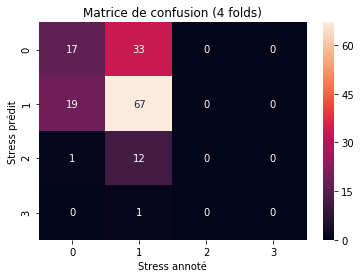

In [91]:
import seaborn as sns 
sns.heatmap(confusion_matrix(ytest_list,ypredict_list),annot=True)
plt.title('Matrice de confusion ('+str(4)+' folds)')
plt.ylabel('Stress prédit')
plt.xlabel('Stress annoté');

In [47]:
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(max_depth=7, n_estimators=100, random_state=42)
rf.fit(Xtrain, ytrain)

ytrain_predict = rf.predict(Xtrain)
ytrain_predict[ytrain_predict<0] = 0.0
ytrain_predict[ytrain_predict>3] = 3.0

ypredict = rf.predict(Xtest)
ypredict[ypredict<0] = 0.0
ypredict[ypredict>3] = 3.0

In [48]:
ypredict_list, ytest_list = [], []

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    rf = RandomForestRegressor(max_depth=7, n_estimators=100, random_state=42)
    rf.fit(Xtrain, ytrain)
    ypredict = rf.predict(Xtest)

    ypredict_list = np.concatenate([ypredict_list,ypredict])
    ytest_list = np.concatenate([ytest_list,ytest])

/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


In [49]:
from sklearn.metrics import r2_score, mean_squared_error
print(mean_squared_error(ytest_list,ypredict_list, squared=False))
print(r2_score(ytest_list,ypredict_list))

0.33685603875045067
0.7391189468048711


In [95]:
ypredict_list, ytest_list = [], []

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
skf.get_n_splits(X_audio, y_audio)

for train_index, test_index in skf.split(X_audio, y_audio):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    rf = RandomForestRegressor(max_depth=7, n_estimators=100, random_state=42)
    rf.fit(Xtrain, ytrain)
    ypredict = rf.predict(Xtest)

    ypredict_list = np.concatenate([ypredict_list,ypredict])
    ytest_list = np.concatenate([ytest_list,ytest])

from sklearn.metrics import r2_score, mean_squared_error
print(mean_squared_error(ytest_list,ypredict_list, squared=False))
print(r2_score(ytest_list,ypredict_list))

/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
0.6159616745122937
0.03266882146971717


## New classifiers

### All diapos

In [98]:
Xtrain = X.loc[train_video_list,:,:]
Xtest = X.loc[test_video_list,:,:]
ytrain = y.loc[train_video_list,:,:]
ytest = y.loc[test_video_list,:,:]

In [99]:
resultats = []

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

#print("TRAIN:", train_index, "TEST:", test_index)
for n_estimators in [100, 150, 200]:
    for max_depth in [5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 20, 25]:
    
        rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
        rf.fit(Xtrain, ytrain)
        ytrain_predict = rf.predict(Xtrain)
        ytest_predict = rf.predict(Xtest)

        resultats.append([n_estimators,max_depth,
                            accuracy_score(ytrain,ytrain_predict),accuracy_score(ytest,ytest_predict),
                            f1_score(ytrain,ytrain_predict,labels=[0,1,2,3],average='weighted'), 
                            f1_score(ytest,ytest_predict,labels=[0,1,2,3],average='weighted')])



/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor 

In [100]:
df_resultats = pd.DataFrame(resultats, columns=['n_estimators', 'max_depth', 'train_acc', 'test_acc', 'train_f1', 'test_f1'])
df_resultats

,n_estimators,max_depth,train_acc,test_acc,train_f1,test_f1
0,100,5,0.952381,0.388889,0.945524,0.359982
1,100,6,0.982143,0.388889,0.981218,0.356725
2,100,7,1.000000,0.375000,1.000000,0.344194
3,100,8,1.000000,0.430556,1.000000,0.401538
4,100,9,1.000000,0.388889,1.000000,0.364329
5,100,10,1.000000,0.444444,1.000000,0.416376
6,100,11,1.000000,0.388889,1.000000,0.364329
7,100,12,1.000000,0.402778,1.000000,0.377575
8,100,13,1.000000,0.388889,1.000000,0.362085
9,100,14,1.000000,0.388889,1.000000,0.362085


/home/neo/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/neo/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/neo/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/neo/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]

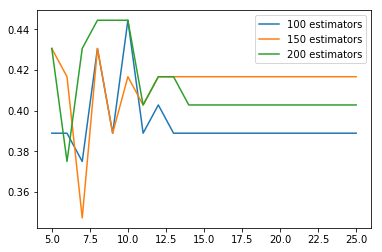

In [101]:
plt.plot(df_resultats.loc[df_resultats.iloc[:,0] == 100].iloc[:,1], df_resultats.loc[df_resultats.iloc[:,0] == 100].iloc[:,3], label='100 estimators')
plt.plot(df_resultats.loc[df_resultats.iloc[:,0] == 150].iloc[:,1], df_resultats.loc[df_resultats.iloc[:,0] == 150].iloc[:,3], label='150 estimators')
plt.plot(df_resultats.loc[df_resultats.iloc[:,0] == 200].iloc[:,1], df_resultats.loc[df_resultats.iloc[:,0] == 200].iloc[:,3], label='200 estimators')
plt.legend();

In [102]:
df_resultats[df_resultats.test_acc == df_resultats.test_acc.max()]

,n_estimators,max_depth,train_acc,test_acc,train_f1,test_f1
5,100,10,1.0,0.444444,1.0,0.416376
29,200,8,1.0,0.444444,1.0,0.415133
30,200,9,1.0,0.444444,1.0,0.415133
31,200,10,1.0,0.444444,1.0,0.410575


In [114]:
max_depth = 9
n_estimators = 200
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
rf.fit(Xtrain, ytrain)
ytrain_predict = rf.predict(Xtrain)
ytest_predict = rf.predict(Xtest)

In [105]:
Xtest.to_pickle(directory_path + '/audio_' + features + '_data_Xtest_audio.p')
ytest_predict.to_pickle(directory_path + '/audio_' + features + '_data_ytest_predict_audio.p')

In [120]:
ytest_and_predict = pd.concat([ytest.reset_index(),pd.DataFrame(ytest_predict,columns=['predicted_stress'])],axis=1).sort_values(['video_name','diapo'])
ytest_and_predict

,video_name,diapo,stress,predicted_stress
0,WIN_20210408_14_11_32_Pro,1,0.0,1.0
1,WIN_20210408_14_11_32_Pro,8,2.0,1.0
2,WIN_20210408_14_11_32_Pro,9,2.0,1.0
3,WIN_20210408_14_11_32_Pro,10,2.0,1.0
4,WIN_20210408_14_11_32_Pro,11,2.0,1.0
...,...,...,...,...
67,WIN_20210417_14_53_12_Pro,10,0.0,1.0
68,WIN_20210417_14_53_12_Pro,11,0.0,1.0
69,WIN_20210417_14_53_12_Pro,12,0.0,1.0
70,WIN_20210417_14_53_12_Pro,17,1.0,0.0


/home/neo/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/neo/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/neo/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


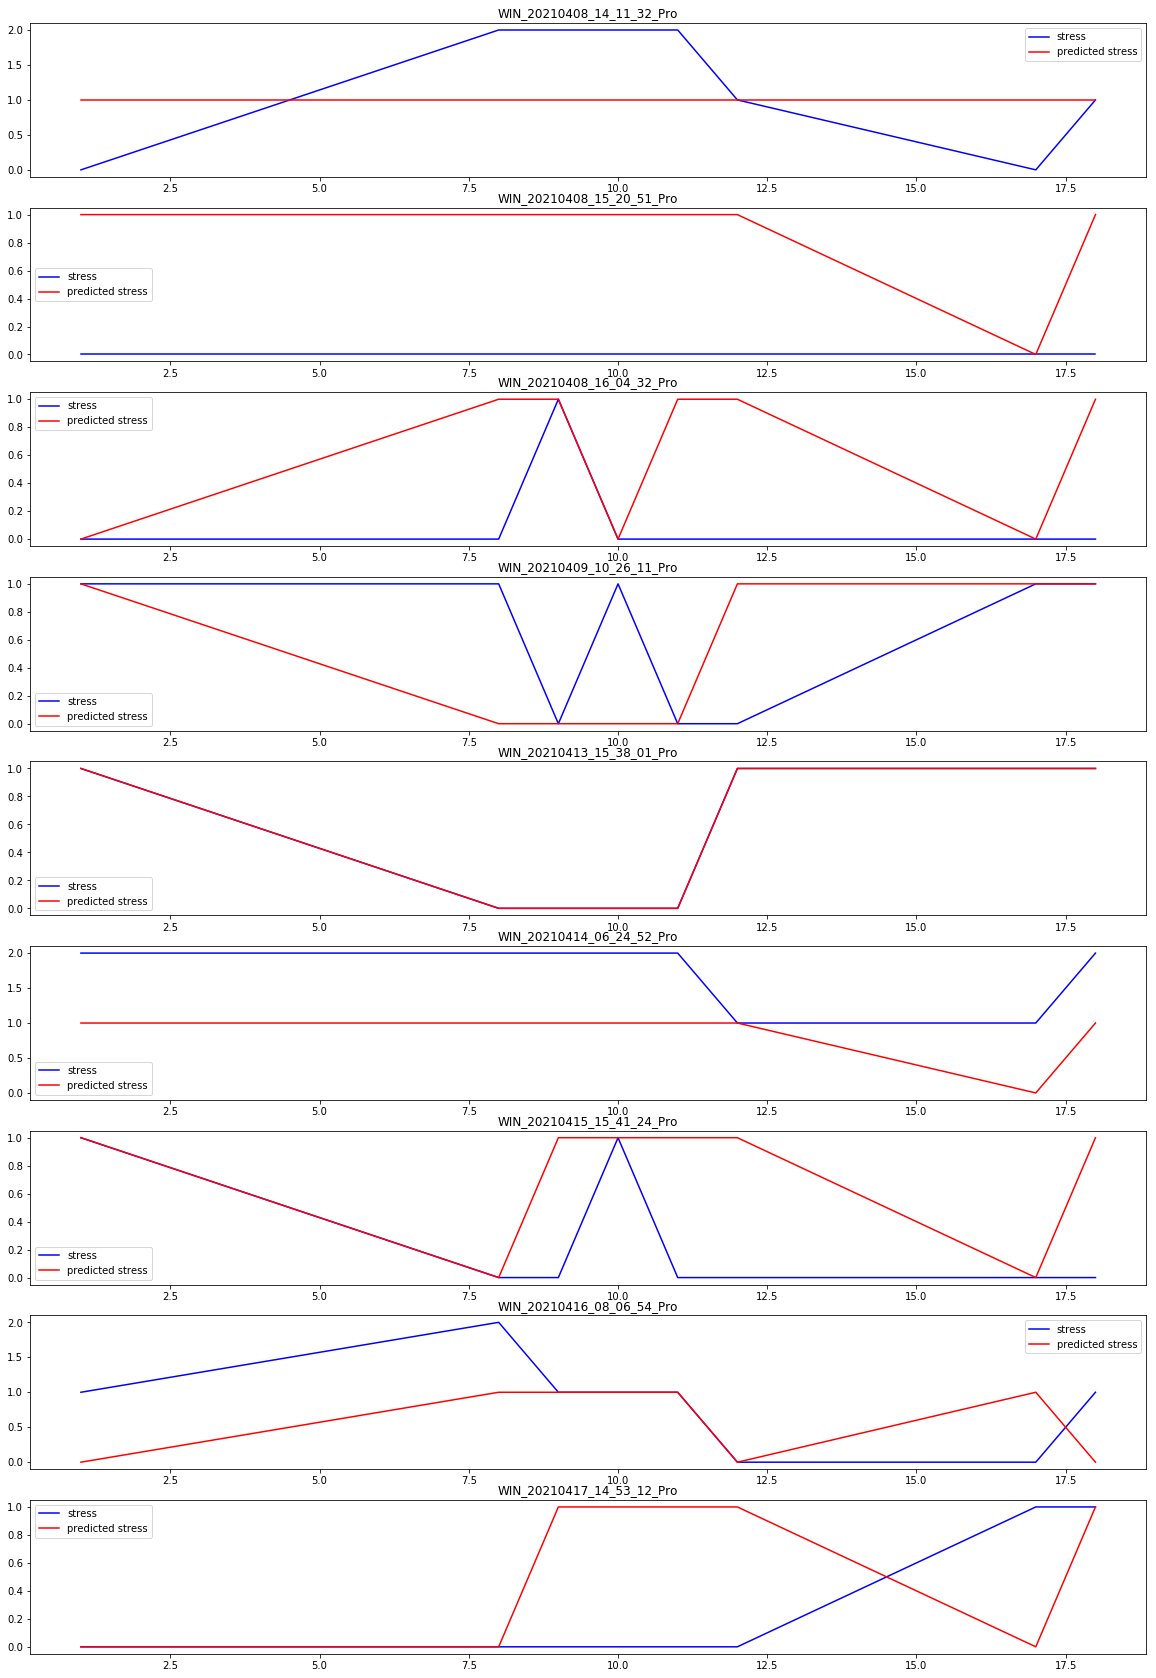

In [121]:

plt.figure(figsize=(20,30))
i = 1
for video_name in ytest_and_predict.video_name.unique():
    plt.subplot(9,1,i)
    plt.title(video_name)
    ind = ytest_and_predict.loc[:,'video_name'] == video_name
    plt.plot(ytest_and_predict.loc[ind,'diapo'], ytest_and_predict.loc[ind,'stress'], 
            color='b', label='stress')
    plt.plot(ytest_and_predict.loc[ind,'diapo'], ytest_and_predict.loc[ind,'predicted_stress'], 
            color='r', label='predicted stress')
    plt.legend();
    i += 1


### Audio diapos only

In [123]:
X = X_audio
y = y_audio

In [124]:
Xtrain = X.loc[train_video_list,:,:]
Xtest = X.loc[test_video_list,:,:]
ytrain = y.loc[train_video_list,:,:]
ytest = y.loc[test_video_list,:,:]

In [125]:
resultats = []

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

#print("TRAIN:", train_index, "TEST:", test_index)
for n_estimators in [100, 150, 200]:
    for max_depth in [5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 20, 25]:
    
        rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
        rf.fit(Xtrain, ytrain)
        ytrain_predict = rf.predict(Xtrain)
        ytest_predict = rf.predict(Xtest)

        resultats.append([n_estimators,max_depth,
                            accuracy_score(ytrain,ytrain_predict),accuracy_score(ytest,ytest_predict),
                            f1_score(ytrain,ytrain_predict,labels=[0,1,2,3],average='weighted'), 
                            f1_score(ytest,ytest_predict,labels=[0,1,2,3],average='weighted')])



/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor 

In [126]:
df_resultats = pd.DataFrame(resultats, columns=['n_estimators', 'max_depth', 'train_acc', 'test_acc', 'train_f1', 'test_f1'])
df_resultats

,n_estimators,max_depth,train_acc,test_acc,train_f1,test_f1
0,100,5,0.980952,0.355556,0.975928,0.331805
1,100,6,1.000000,0.377778,1.000000,0.356558
2,100,7,1.000000,0.377778,1.000000,0.348456
3,100,8,1.000000,0.422222,1.000000,0.391358
4,100,9,1.000000,0.422222,1.000000,0.393603
5,100,10,1.000000,0.422222,1.000000,0.393603
6,100,11,1.000000,0.422222,1.000000,0.393603
7,100,12,1.000000,0.422222,1.000000,0.393603
8,100,13,1.000000,0.422222,1.000000,0.393603
9,100,14,1.000000,0.422222,1.000000,0.393603


In [127]:
df_resultats[df_resultats.test_acc == df_resultats.test_acc.max()]

,n_estimators,max_depth,train_acc,test_acc,train_f1,test_f1
3,100,8,1.0,0.422222,1.0,0.391358
4,100,9,1.0,0.422222,1.0,0.393603
5,100,10,1.0,0.422222,1.0,0.393603
6,100,11,1.0,0.422222,1.0,0.393603
7,100,12,1.0,0.422222,1.0,0.393603
8,100,13,1.0,0.422222,1.0,0.393603
9,100,14,1.0,0.422222,1.0,0.393603
10,100,15,1.0,0.422222,1.0,0.393603
11,100,20,1.0,0.422222,1.0,0.393603
12,100,25,1.0,0.422222,1.0,0.393603


In [128]:
max_depth = 9
n_estimators = 100
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
rf.fit(Xtrain, ytrain)
ytrain_predict = rf.predict(Xtrain)
ytest_predict = rf.predict(Xtest)

/home/neo/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/neo/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/neo/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


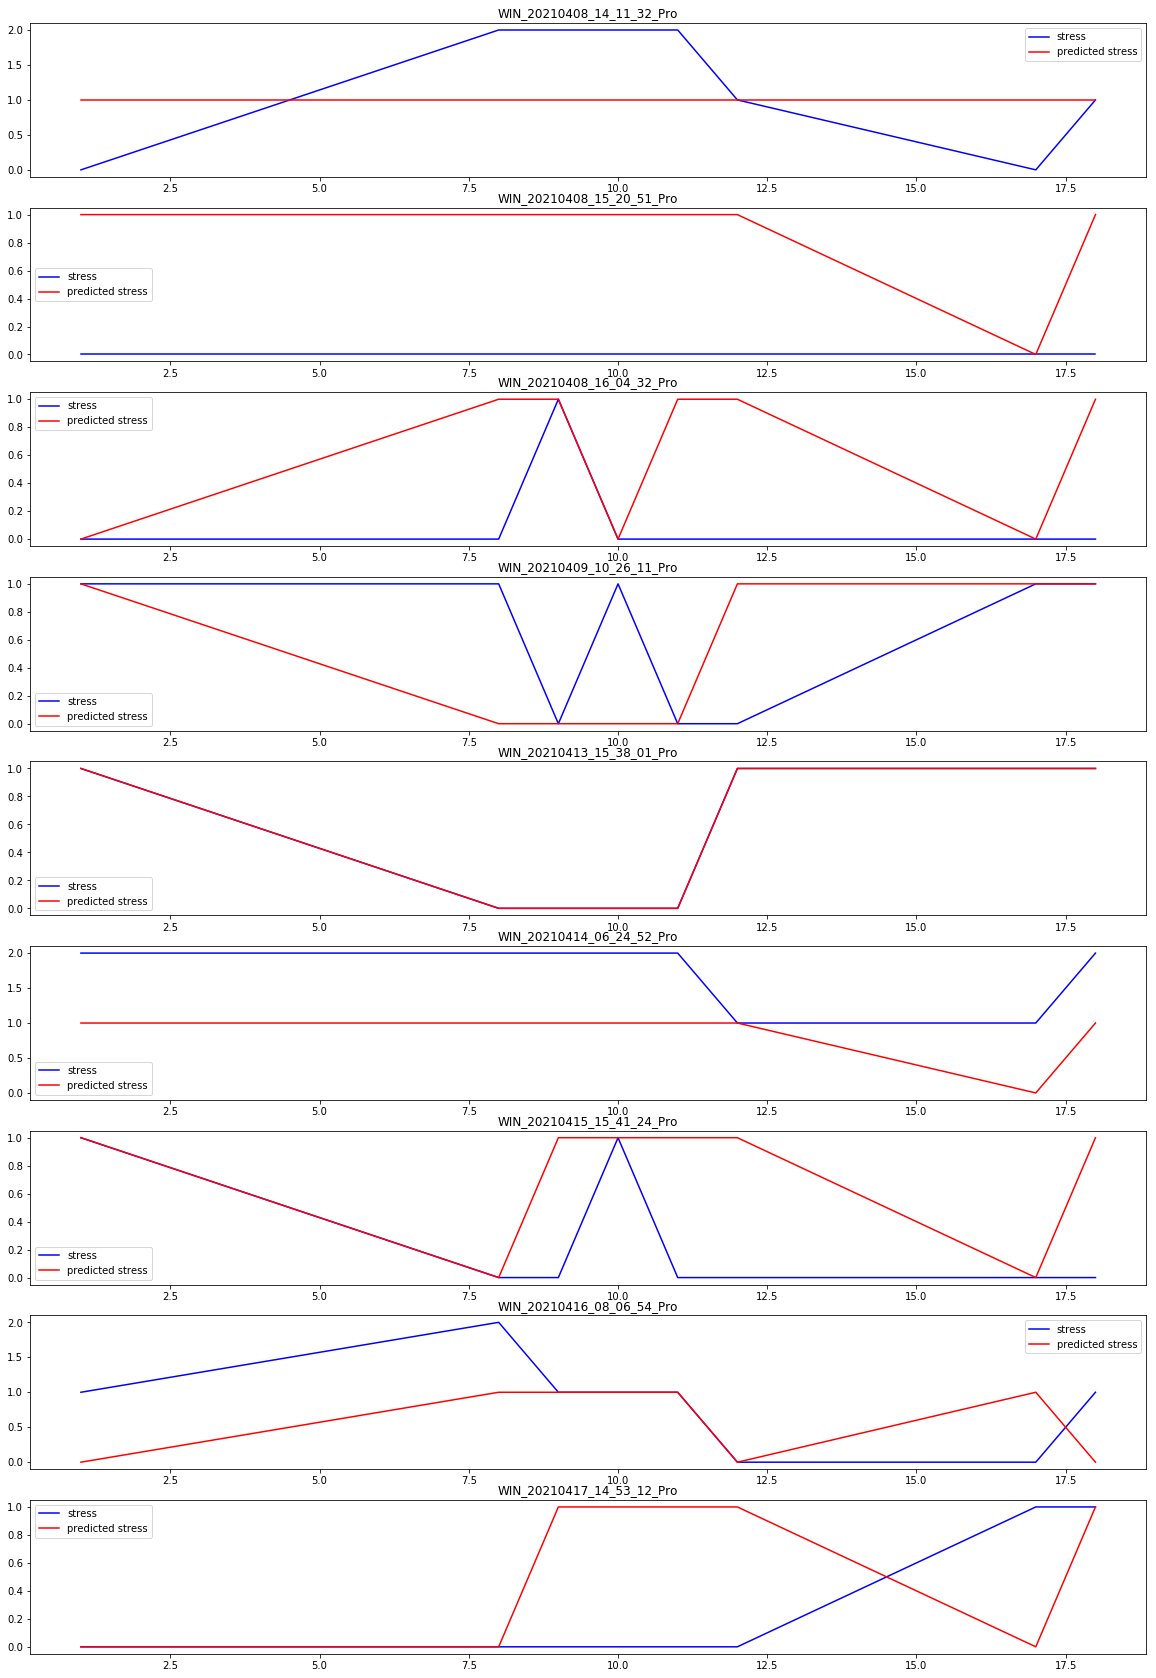

In [129]:

plt.figure(figsize=(20,30))
i = 1
for video_name in ytest_and_predict.video_name.unique():
    plt.subplot(9,1,i)
    plt.title(video_name)
    ind = ytest_and_predict.loc[:,'video_name'] == video_name
    plt.plot(ytest_and_predict.loc[ind,'diapo'], ytest_and_predict.loc[ind,'stress'], 
            color='b', label='stress')
    plt.plot(ytest_and_predict.loc[ind,'diapo'], ytest_and_predict.loc[ind,'predicted_stress'], 
            color='r', label='predicted stress')
    plt.legend();
    i += 1


#### Leave one interview out

In [5]:
video_name_list = X.reset_index().video_name.unique()

In [31]:
X = X.reset_index()
y = y.reset_index()


In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore")

max_depth = 10
n_estimators = 100
split = 0

In [74]:
resultats = []
split = 0

for n_estimators in [100, 150, 200]:
    for max_depth in [5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 20, 25]:

        split = 0
        for video_name in video_name_list:
            Xtrain = X[X.video_name != video_name].set_index(['video_name','diapo'])
            ytrain = y[X.video_name != video_name].set_index(['video_name','diapo'])
            Xtest = X[X.video_name == video_name].set_index(['video_name','diapo'])
            ytest = y[X.video_name == video_name].set_index(['video_name','diapo'])

            rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42, n_jobs=-1)
            rf.fit(Xtrain, ytrain.values.ravel())
            ytrain_predict = rf.predict(Xtrain)
            ytest_predict = rf.predict(Xtest)

            resultats.append([n_estimators,max_depth,split,
                                accuracy_score(ytrain,ytrain_predict),accuracy_score(ytest,ytest_predict)])
                                #f1_score(ytrain,ytrain_predict,labels=[0,1,2,3],average='weighted'), 
                                #f1_score(ytest,ytest_predict,labels=[0,1,2,3],average='weighted')])
            split += 1


df_resultats = pd.DataFrame(resultats, columns=['n_estimators', 'max_depth', 'split','train_acc', 'test_acc'])
df_resultats_agg = df_resultats.groupby(['n_estimators', 'max_depth']).agg({'train_acc':['mean','std'], 
                                                                            'test_acc':['mean','std']})
df_resultats_agg


train_acc            test_acc          
                            mean       std      mean       std
n_estimators max_depth                                        
100          5          0.942098  0.012069  0.475000  0.226004
             6          0.987787  0.006800  0.441667  0.221995
             7          0.996408  0.002287  0.441667  0.196229
             8          0.999282  0.001634  0.416667  0.208477
             9          0.999856  0.000787  0.404167  0.216962
             10         1.000000  0.000000  0.408333  0.207441
             11         1.000000  0.000000  0.383333  0.222479
             12         1.000000  0.000000  0.408333  0.224888
             13         1.000000  0.000000  0.408333  0.236564
             14         1.000000  0.000000  0.425000  0.228846
             15         1.000000  0.000000  0.420833  0.228572
             20         1.000000  0.000000  0.429167  0.233700
             25         1.000000  0.000000  0.429167  0.233700
150          5          0.945977  0.010842  0.462500  0.230138
             6          0.991954  0.004039  0.466667  0.222479
             7          0.995977  0.001574  0.445833  0.216962
             8          0.999425  0.001490  0.450000  0.211725
             9          0.999856  0.000787  0.433333  0.236108
             10         1.000000  0.000000  0.420833  0.195541
             11         1.000000  0.000000  0.445833  0.229043
             12         1.000000  0.000000  0.466667  0.212572
             13         1.000000  0.000000  0.429167  0.229043
             14         1.000000  0.000000  0.441667  0.226797
             15         1.000000  0.000000  0.458333  0.228218
             20         1.000000  0.000000  0.450000  0.228846
             25         1.000000  0.000000  0.450000  0.228846
200          5          0.948132  0.011176  0.466667  0.224888
             6          0.993534  0.002941  0.458333  0.244185
             7          0.996839  0.001939  0.466667  0.210022
             8          0.999856  0.000787  0.445833  0.226678
             9          1.000000  0.000000  0.437500  0.236146
             10         1.000000  0.000000  0.445833  0.198820
             11         1.000000  0.000000  0.433333  0.233815
             12         1.000000  0.000000  0.454167  0.240069
             13         1.000000  0.000000  0.450000  0.235804
             14         1.000000  0.000000  0.441667  0.242858
             15         1.000000  0.000000  0.441667  0.236108
             20         1.000000  0.000000  0.445833  0.240517
             25         1.000000  0.000000  0.445833  0.240517

In [108]:
df_resultats_agg.loc[df_resultats_agg.iloc[:,2] == df_resultats_agg.iloc[:,2].max()].index

MultiIndex([(100, 5)],
           names=['n_estimators', 'max_depth'])

In [110]:

max_depth = 5
n_estimators = 100
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
rf.fit(X.set_index(['video_name','diapo']), y.set_index(['video_name','diapo']).values.ravel())
y_predict = rf.predict(X.set_index(['video_name','diapo']))


In [121]:
df_ypredict = pd.concat([X[['video_name','diapo']],pd.DataFrame(y_predict, columns=['ypredict'])],axis=1)
df_ypredict.to_csv('ypredict_audio_diapo.csv')
